# **Análisis de precios de casas en venta en las principales ciudades de Paraguay**

---


Datos: Los datos son obtenidos mediante web scraping a las dos paginas más importantes de venta de inmuebles.



Este mini proyecto nace cuando empecé a buscar viviendas con el objetivo de comprar una. Viendo los precios tan altos en Asunción, me propuse investigar en qué ciudad estarían las viviendas mas accecibles, y también los precios de las viviendas en la ciudad donde me gustaría vivir.

Se me ocurrió realizar un sencillo scraping utilizando BeautifulSoup en Python, de forma a obtener los datos necesarios para el análisis.

In [2]:
#primeramente utilizo un fake-useragent para realizar los scrapeos.
!pip install fake-useragent

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=786d7c4291f4cf3be0dd7dd77650e3eee43141457f7a4762b23dbe87345720fc
  Stored in directory: /root/.cache/pip/wheels/ed/f7/62/50ab6c9a0b5567267ab76a9daa9d06315704209b2c5d032031
Successfully built fake-useragent


In [3]:
#importar las librerias a utilizar
import warnings
warnings.filterwarnings("ignore")

from bs4 import BeautifulSoup
from IPython.display import HTML
import requests
import pandas as pd
import numpy as np
from fake_useragent import UserAgent
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

#desactivo la notación científica
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
#Creo listas donde se almacenara la informacion
house=[] #lista para guardar el nombre de la casa
prices=[] #lista para guardar el precio de la casa
location = [] #lista para guardar la ciudad donde se ubica la casa

df=pd.DataFrame()

UserAgent :
La cadena de agente de usuario ayuda al servidor de destino a identificar qué navegador, tipo de dispositivo y sistema operativo se está utilizando.

In [ ]:
#utilizo el fake_useragent para simular a un usuario real 
user_agent = UserAgent()

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/fake_useragent/utils.py", line 154, in load
    for item in get_browsers(verify_ssl=verify_ssl):
  File "/usr/local/lib/python3.7/dist-packages/fake_useragent/utils.py", line 99, in get_browsers
    html = html.split('<table class="w3-table-all notranslate">')[1]
IndexError: list index out of range


Scrapeo 1000 registros de la página de Clasipar, una de los sitios más populares en Py.



---

Scrapeando la primera página de inmuebles

---



In [ ]:
url = "https://clasipar.paraguay.com/inmuebles/casas/intencion:vendo-t_s/page-1"
page = requests.get(url, headers={"user-agent": user_agent.chrome})
html = page.content
page_soup = BeautifulSoup(html, "html.parser")

In [ ]:
#extraer los datos de las casas, precios y ubicacion y volcarlos en un dataframe
for i in range(1,500):
    url = "https://clasipar.paraguay.com/inmuebles/casas/intencion:vendo-t_s/page-1"
    #url = url.format(product_name,i)

    ## getting the reponse from the page using get method of requests module
    page = requests.get(url, headers={"user-agent": user_agent.chrome})

    ## storing the content of the page in a variable
    html = page.content

    ## creating BeautifulSoup object
    page_soup = BeautifulSoup(html, "html.parser")

    for containers in page_soup.findAll('div',{'class':'box-anuncio__descripcion'}):
        name=containers.find('a', attrs={'class':'titAnuncio'})
        price=containers.find('p', attrs={'class':'price'})
        address = containers.select_one("h6 a").text.replace('\n','')
        house.append(name.text.replace('\n',''))
        prices.append(price.text.replace('\n',''))
        location.append(address)

    casas = pd.DataFrame({'Name':house,'Price':prices, 'Location':location})

In [ ]:
df = casas
df.head()

,Name,Price,Location
0,Casas en Limpio en Barrio Cerrado Residencial ...,Gs. 380.000.000,Casas en Limpio
1,"Oferta!! Vendo casa en Villa Elisa, en Villa SNT",Gs. 320.000.000,Casas en Villa Elisa
2,VENDO Encantadora Casa - Complejo Surubii,"US$. 175.000,00",Casas en Mariano Roque Alonso
3,Vendo en Lambare amplia casa,Gs. 1.582.000.000,Casas en Lambaré
4,VENDO CASA ZONA CAPIATA,Gs. 720.000.000,Casas en Capiatá


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67528 entries, 0 to 67527
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Name      67528 non-null  object
 1   Price     67528 non-null  object
 2   Location  67528 non-null  object
dtypes: object(3)
memory usage: 1.5+ MB


# Data Wrangling

Luego de obtener los datos necesarios, procedí a crear nuevos features y tambien y a limpiar otros que, debido a la forma en como extraje los datos pudieron quedar incoherentes.


In [ ]:
#Los precios estan en guaranies y dolares, por lo que seria util diferenciarlos y unificarlos. 
#Para ello creare dos nuevas columnas de precios: uno solo Gs y otro solo U$D.
#Antes, debo diferenciar el tipo de moneda de cada uno,

#Creo una columna para identificar el tipo de moneda
df['moneda'] = df['Price'].str.slice(0, 2)

#Creo otra columna con el cod. de la moneda
df['cod_moneda'] = np.where(df['moneda']=='US', 2, 1)

#Agrego la columna de precio del dolar en gs
df['cot_dolar'] = 7000

In [ ]:
#Elimino las publicaciones que no tienen precio disponible
#df.loc[df['precio']=='ultar precio']
df.drop(df.loc[df['moneda']=='CO'].index, inplace=True)
df.drop(df.loc[df['moneda']=='Co'].index, inplace=True)

In [ ]:
#PRECIOS
#Creo otra columna solo con el precio, sin la moneda
df['precio'] = df['Price'].str.slice(4, 100)

#extraigo la parte decimal de los precios en dolares.
df['precio'] = df['precio'].str.split(',').str[0]

#cambio el tipo de datos a int
df['precio']=df['precio'].replace('\.','',regex=True).astype(int)
#df['precio']=df['precio'].replace('\,','',regex=True).astype(int)

#obtengo el precio en gs
df['precio_gs'] = np.where(df.moneda =='US', df.precio*df.cot_dolar, df.precio)

#obtengo el precio en U$D
df['precio_usd'] = np.round(np.where(df.moneda =='Gs', df.precio/df.cot_dolar, df.precio),0)


In [ ]:
#CIUDAD
#Creo una columna para obtener la cuidad de ubicación
df['ciudad'] = df['Location'].str.slice(10, 100)
#cambio a tipo string
df['ciudad'] = df['ciudad'].astype(str)

In [ ]:
#Guarda datos en CSV:
df.to_csv('casas_clasipar.csv', header=True, index=False)

In [ ]:
#guardo el dataframe en google.drive
from google.colab import drive
drive.mount('drive')

df.to_csv('casas_clasipar.csv')
!cp casas_clasipar.csv "/content/drive/MyDrive/Colab Notebooks/Portfolio/bases"

Mounted at drive




---

Scrapeando la segunda pagina de inmuebles

---



In [ ]:
house2=[] #List to store name of the house
prices2=[] #List to store price of the house
location2 = [] #List of location of the house
df_infocasas = pd.DataFrame()

In [ ]:
#uso esta libreria para evitar inconvenientes con el fake user agent
from fake_useragent import UserAgent
#ua = UserAgent()

In [ ]:
user_agent = UserAgent()

In [ ]:
user_agent

In [ ]:
url = "https://www.infocasas.com.py/venta/casas-y-departamentos"
page = requests.get(url, headers={"user-agent": user_agent.chrome})
html = page.content
page_soup = BeautifulSoup(html, "html.parser")

In [ ]:
#print(page_soup.prettify)

In [ ]:
#extraer los datos de las casas, precios y ubicacion y volcarlos en un dataframe
for i in range(1,5):
    url = "https://www.infocasas.com.py/venta/casas-y-departamentos"
    #url = url.format(product_name,i)

    ## getting the reponse from the page using get method of requests module
    page = requests.get(url, headers={"user-agent": user_agent.chrome})
    #wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
    #wd.get(url)

    ## storing the content of the page in a variable
    html = page.content

    ## creating BeautifulSoup object
    page_soup = BeautifulSoup(html, "html.parser")

    for containers in page_soup.findAll('div',{'class':'ant-card-body'}):
        #topography = containers.find_elements_by_xpath('//span[c]')
        tipo = containers.find_all('span', attrs={'ant-typography ant-typography-ellipsis'})[0].text
        cant_banio = containers.find_all('span', attrs={'ant-typography ant-typography-ellipsis'})[1].text
        m2 = containers.find_all('span', attrs={'ant-typography ant-typography-ellipsis'})[2].text
        price = containers.find('span', attrs={'class':'ant-typography price'})
        edificio = containers.find('h4',attrs={'ant-typography ant-typography-ellipsis property-title'}).text
        ciudad = containers.find('span', attrs={'property-location-tag'}).text
        
        house2.append(tipo)
        prices2.append(price.text.replace('\n',''))
        #location.append(address)
    
#    listaCasas = wd.find_elements_by_class_name("ant-card-body")
#    locations = []
#    for casa in listaCasas:
#      print()
#      locations.append(casa.find_element_by_class_name('property-location-tag').text)

    casas = pd.DataFrame({'tipo':tipo,
                          'cant_baño':cant_banio,
                          'metros_2': m2,
                          'precio':prices2,
                          'edificio':edificio,
                          'ciudad':ciudad})

In [ ]:
info_casas = casas
info_casas.head()

In [ ]:
#guardar df raw
#guardo el dataframe en google.drive
from google.colab import drive
drive.mount('drive')

In [ ]:
info_casas.to_csv('casas_infocasas.csv')
!cp casas_infocasas.csv "/content/drive/MyDrive/Colab Notebooks/Portfolio/bases"

# **Exploratory Data Analysis**

### Lectura de base

Como ya habia guardado la base limpia y con las nuevas variables; paso a leer esa base para realizar el analisis.

In [4]:
#Leer el csv guardado anteriormente
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
df=pd.read_csv('/ubicacion/casas_precios.csv')

### Nuevo dataframe

Defino un nuevo dataframe con el cual trabajare

In [10]:
df.columns

Index(['Unnamed: 0', 'Name', 'Price', 'Location', 'moneda', 'cod_moneda',
       'cot_dolar', 'precio', 'precio_gs', 'precio_usd', 'ciudad'],
      dtype='object')

filtro solo las variables que utilizare para el análisis en un nuevo df.

In [11]:
data = df[['Name','ciudad','precio_gs','precio_usd']]

In [12]:
#examinar el dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66595 entries, 0 to 66594
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Name        66595 non-null  object 
 1   ciudad      66595 non-null  object 
 2   precio_gs   66595 non-null  int64  
 3   precio_usd  66595 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.0+ MB


In [13]:
data.describe()

,precio_gs,precio_usd
count,66595.000,66595.000
mean,7261688205.569,1037384.029
std,180982479790.966,25854639.970
min,1.000,0.000
25%,500000000.000,71429.000
50%,1050000000.000,150000.000
75%,1750000000.000,250000.000
max,12950000000000.000,1850000000.000


### Normalizacion de datos

Muchas variables traen valores incoherentes o valores nulos, por lo que debemos unificarlas de forma a tener información util a analizar.

La variable ciudad es una de las que trae los nombres de las ciudades escritos a media, mal escritos o con mayusculas/minisculas o combinación. Es necesario unificar los valores.


In [14]:
#normalizacion de datos
#Veo que hay registros con los nombres de las ciudades cortados, por lo que hay que solucionar

#data['ciudad'].unique().tolist()

print(sorted(data['ciudad']))

['Acahay ', 'Acahay ', 'Acahay ', 'Acahay ', 'Acahay ', 'Acahay ', 'Acahay ', 'Acahay ', 'Acahay ', 'Acahay ', 'Acahay ', 'Acahay ', 'Alto Paraná ', 'Alto Paraná ', 'Alto Paraná ', 'Alto Paraná ', 'Alto Paraná ', 'Alto Paraná ', 'Alto Paraná ', 'Alto Paraná ', 'Alto Paraná ', 'Alto Paraná ', 'Alto Paraná ', 'Alto Paraná ', 'Alto Paraná ', 'Alto Paraná ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Altos ', 'Al

In [15]:
data.loc[data['ciudad'] == 'ambaré', 'ciudad'] = 'Lambaré'
data.loc[data['ciudad'] == 'uque', 'ciudad'] = 'Luque'
data.loc[data['ciudad'] == 'an Antonio', 'ciudad'] = 'San Antonio'
data.loc[data['ciudad'] == 'an Bernardino', 'ciudad'] = 'San Bernardino'
data.loc[data['ciudad'] == 'an Lorenzo', 'ciudad'] = 'San Lorenzo'
data.loc[data['ciudad'] == 'apiatá', 'ciudad'] = 'Capiatá'
data.loc[data['ciudad'] == 'ariano Roque Alonso', 'ciudad'] = 'Mariano Roque Alonso'
data.loc[data['ciudad'] == 'ernando de la Mora', 'ciudad'] = 'Fernando de la Mora'
data.loc[data['ciudad'] == 'illa Elisa', 'ciudad'] = 'Villa Elisa'
data.loc[data['ciudad'] == 'impio', 'ciudad'] = 'Limpio'
data.loc[data['ciudad'] == 'iudad del Este', 'ciudad'] = 'Ciudad del Este'
data.loc[data['ciudad'] == 'ltos', 'ciudad'] = 'Altos'
data.loc[data['ciudad'] == 'mboscada', 'ciudad'] = 'Emboscada'
data.loc[data['ciudad'] == 'ncarnación', 'ciudad'] = 'Encarnacion'
data.loc[data['ciudad'] == 'sunción', 'ciudad'] = 'Asunción'
data.loc[data['ciudad'] == 'tauguá', 'ciudad'] = 'Itauguá'
data.loc[data['ciudad'] == 'emby', 'ciudad'] = 'Ñemby'
data.loc[data['ciudad'] == 'reguá', 'ciudad'] = 'Areguá'

In [16]:
#elimino los espacios en blanco
data['ciudad'] = data['ciudad'].str.strip()

In [17]:
#cantidad de casas ofrecidas por ciudad
data.groupby('ciudad').size()

ciudad
Acahay                 12
Alto Paraná            14
Altos                 237
Areguá               1012
Arroyos y Esteros      11
                     ... 
illa Florida          161
illa del Rosario      194
pané                  340
tá                    213
Ñemby                1460
Length: 127, dtype: int64

In [18]:
#print(sorted(data['ciudad'], reverse=False))
sorted(data['ciudad'], reverse=False)

['Acahay',
 'Acahay',
 'Acahay',
 'Acahay',
 'Acahay',
 'Acahay',
 'Acahay',
 'Acahay',
 'Acahay',
 'Acahay',
 'Acahay',
 'Acahay',
 'Alto Paraná',
 'Alto Paraná',
 'Alto Paraná',
 'Alto Paraná',
 'Alto Paraná',
 'Alto Paraná',
 'Alto Paraná',
 'Alto Paraná',
 'Alto Paraná',
 'Alto Paraná',
 'Alto Paraná',
 'Alto Paraná',
 'Alto Paraná',
 'Alto Paraná',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Altos',
 'Al

### Analisis de precios

In [19]:
#Precio promedio
pd.options.display.float_format = '{:.0f}'.format

(data.groupby(['ciudad'], as_index=False).mean()
.groupby('ciudad')['precio_gs'].mean())

ciudad
Acahay               861250016
Alto Paraná         2345000000
Altos               2309193671
Areguá               995565840
Arroyos y Esteros    501818182
                       ...    
illa Florida         500000000
illa del Rosario      70000000
pané                 470147059
tá                   240000000
Ñemby                671175103
Name: precio_gs, Length: 127, dtype: float64

In [20]:
data.groupby(['ciudad']).mean().groupby(['ciudad']).mean()

,precio_gs,precio_usd
ciudad,,
Acahay,861250016,123036
Alto Paraná,2345000000,335000
Altos,2309193671,329885
Areguá,995565840,142224
Arroyos y Esteros,501818182,71688
...,...,...
illa Florida,500000000,71429
illa del Rosario,70000000,10000
pané,470147059,67164


In [21]:
#verifico por que hay precios tan altos.
df[df['precio_usd']> 1000000]

,Unnamed: 0,Name,Price,Location,moneda,cod_moneda,cot_dolar,precio,precio_gs,precio_usd,ciudad
71,73,VENDO RESIDENCIA BARRIO LOS LAURELES,"US$. 1.400.000,00",Casas en Asunción,US,2,7000,1400000,9800000000,1400000,Asunción
126,128,VENDO TERRENO DE 6.500 M2 EN EL BARRIO SAN CRI...,"US$. 5.200.000,00",Casas en Asunción,US,2,7000,5200000,36400000000,5200000,Asunción
148,150,Casa única en el Corazón de Paraná Country Clu...,"US$. 1.250.000,00",Casas en Hernandarias,US,2,7000,1250000,8750000000,1250000,ernandarias
171,174,VENDO LUJOSA CASA EN LAMBARE SOBRE LUIS MARIA ...,"US$. 1.250.000,00",Casas en Lambaré,US,2,7000,1250000,8750000000,1250000,Lambaré
276,283,Casa única en el Corazón de Paraná Country Clu...,"US$. 1.250.000,00",Casas en Hernandarias,US,2,7000,1250000,8750000000,1250000,ernandarias
...,...,...,...,...,...,...,...,...,...,...,...
66366,67296,VENDO CASA DE VERANO EN SANBER CON VISTA AL LA...,"US$. 1.150.000,00",Casas en San Bernardino,US,2,7000,1150000,8050000000,1150000,San Bernardino
66456,67386,VENDO IMPORTANTE PROPIEDAD INDUSTRIAL EN VILLETA,"US$. 1.650.000,00",Casas en Villeta,US,2,7000,1650000,11550000000,1650000,Villeta
66523,67455,Casa única en el Corazón de Paraná Country Clu...,"US$. 1.250.000,00",Casas en Hernandarias,US,2,7000,1250000,8750000000,1250000,ernandarias
66537,67469,Espectacular casa en RECOLETA!!,"US$. 1.200.000,00",Casas en Asunción,US,2,7000,1200000,8400000000,1200000,Asunción


In [22]:
# Checking the missing values
data.isnull().sum()

Name          0
ciudad        0
precio_gs     0
precio_usd    0
dtype: int64

### Handling Outliers


Casas con precios muy muy altos o muy bajos, hay que eliminarlos por que ensucian el analisis

In [23]:
data['precio_gs'].describe()

count            66595
mean        7261688206
std       180982479791
min                  1
25%          500000000
50%         1050000000
75%         1750000000
max     12950000000000
Name: precio_gs, dtype: float64

In [24]:
#elimino las casas con precios muy elevados
data.drop(data[data['precio_gs'] > 1000000000].index, inplace = True)

In [25]:
#elimino las casas con precios menores a 100.000.000 gs, que normalmente pertenecen a anuncios que no quisieron poner el precio real
data.drop(data[data['precio_gs'] < 100000000].index, inplace = True)

In [26]:
#vuelvo a verificar la distribucion de la variable
data['precio_gs'].describe()

count        29530
mean     538704501
std      235422309
min      100000000
25%      340000000
50%      525000000
75%      735000000
max     1000000000
Name: precio_gs, dtype: float64

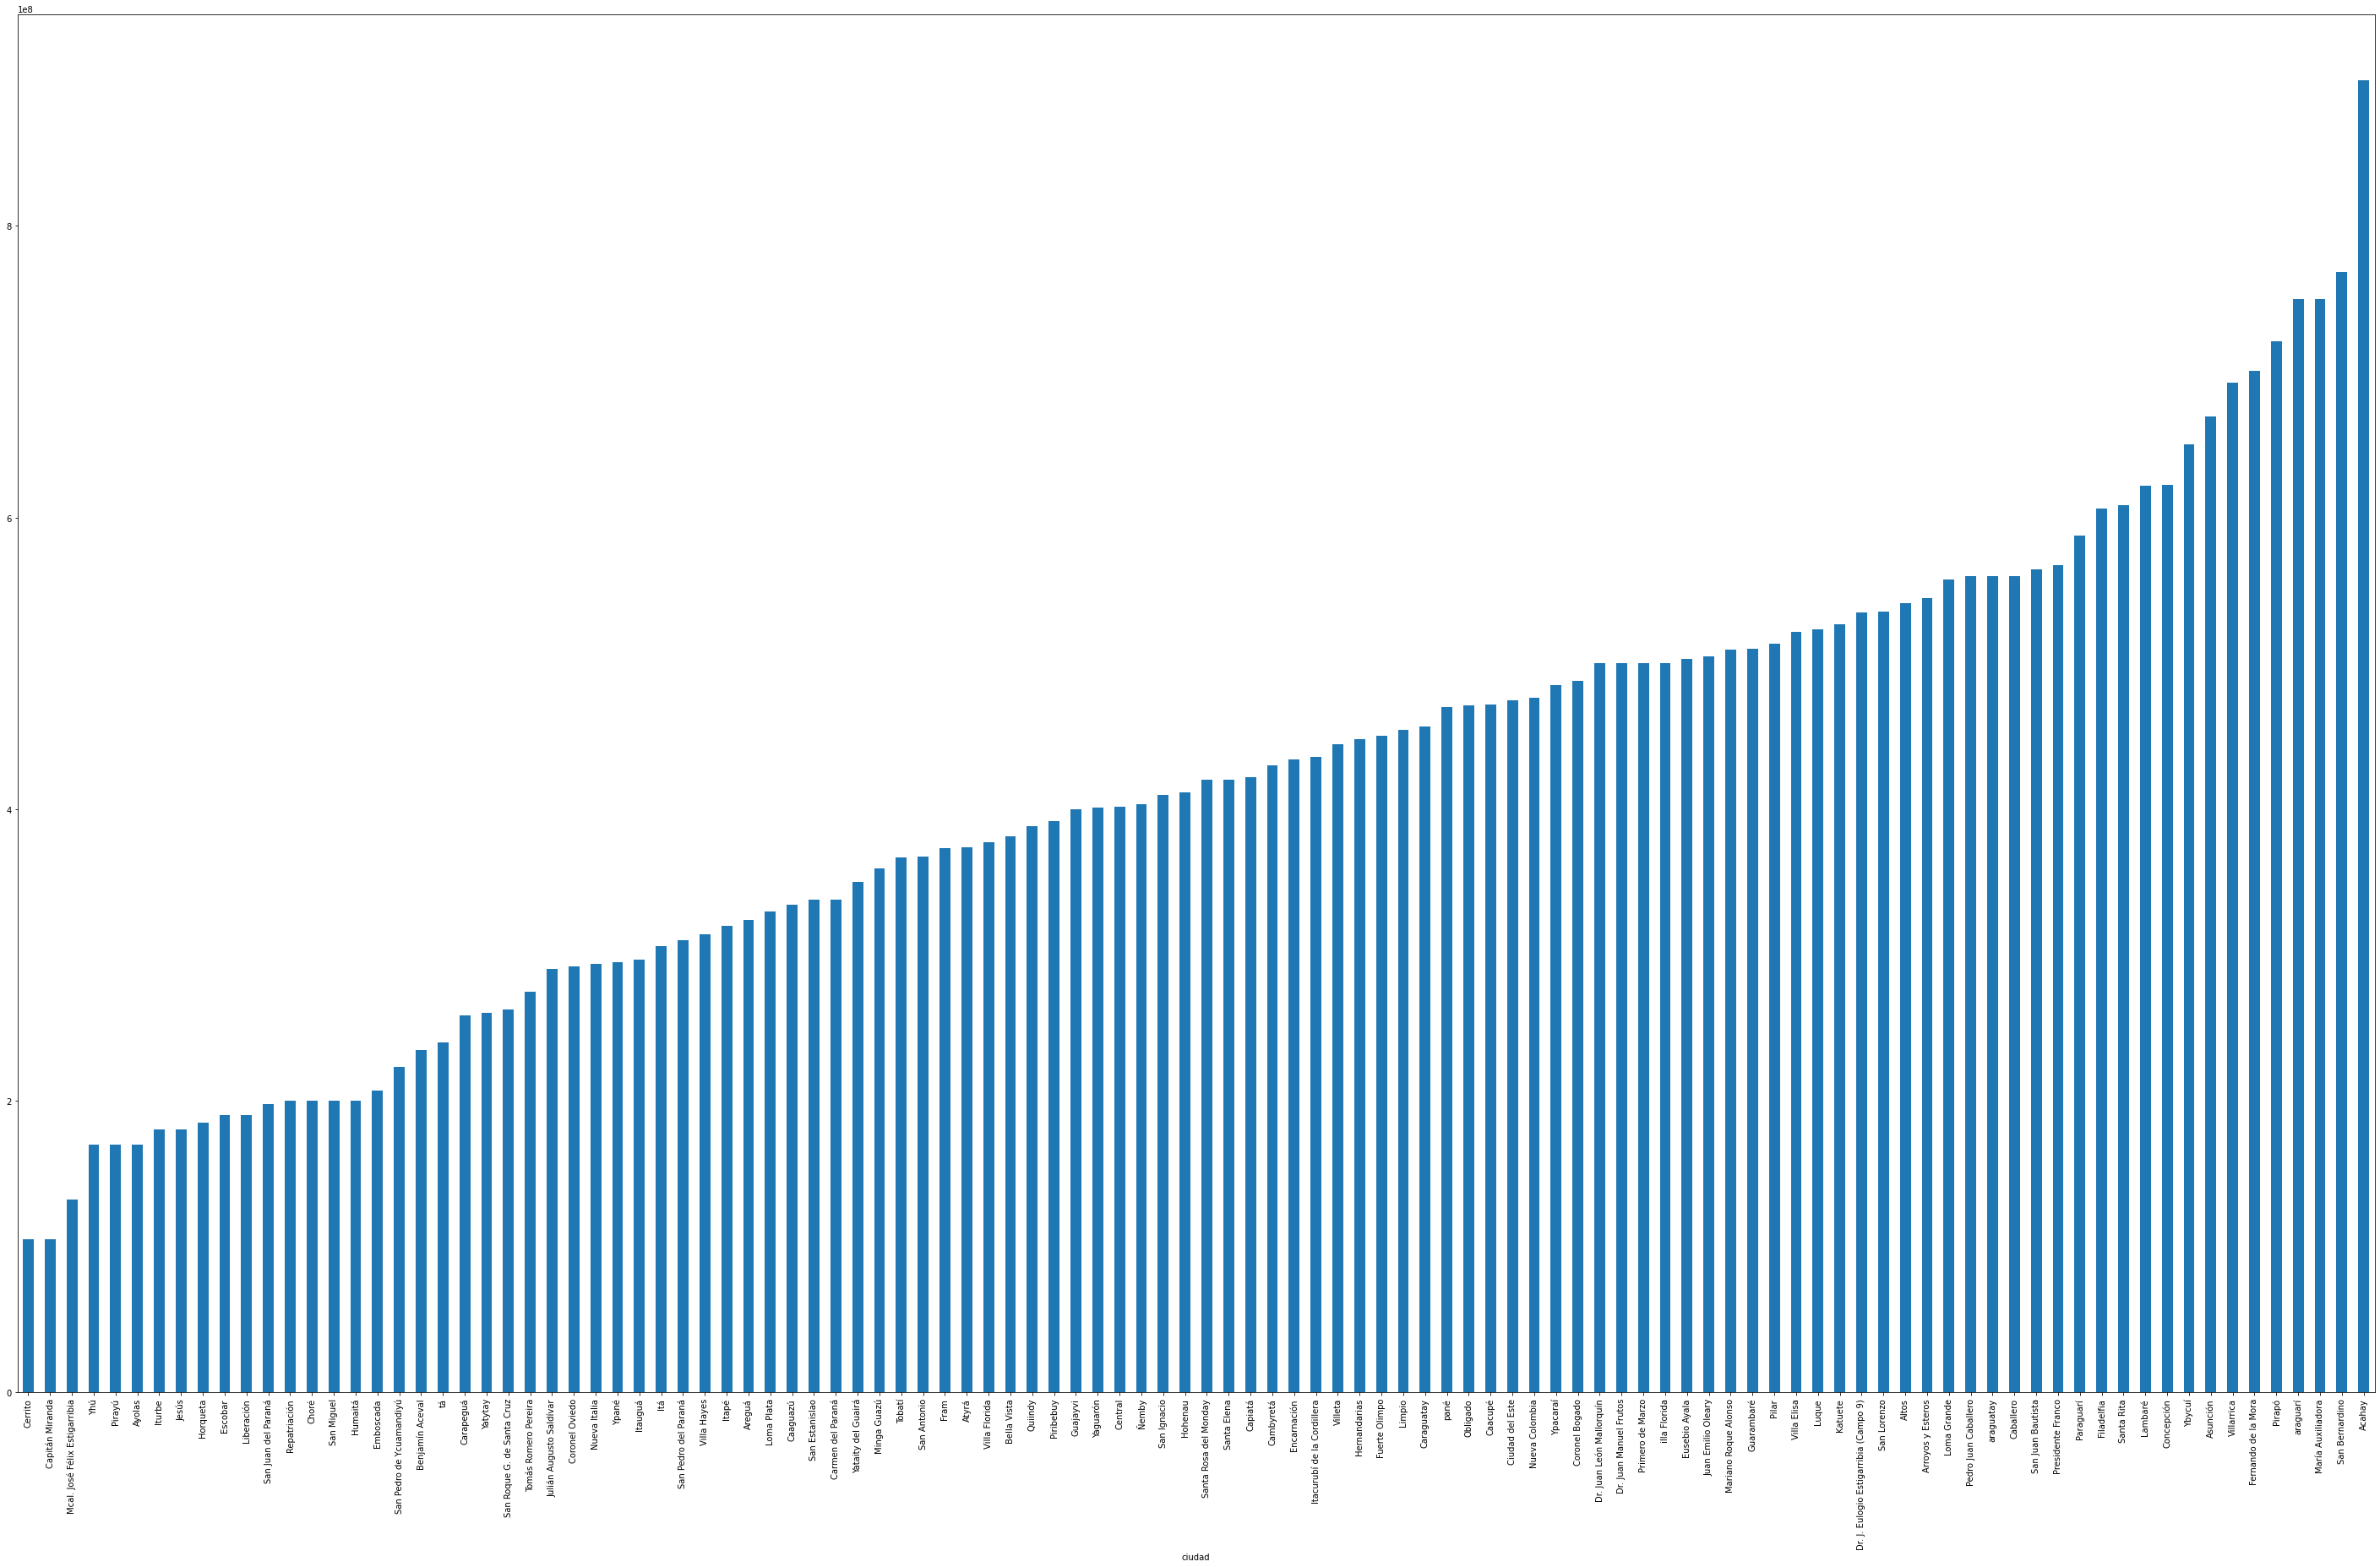

In [27]:
#plot the bar graph of cities with average value of price_usd
plt.figure(figsize=(50, 30))
data.groupby('ciudad')['precio_gs'].mean().sort_values().plot.bar()
plt.show()

Como vemos son muchas las ciudades y es dificil apreciar el grafico por completo.

Elijo el top 10 de las ciudades con casas mas costosas y el top 10 de las ciudades con casas mas baratas para mejor apreciacion

In [28]:
data_group = pd.DataFrame(data.groupby('ciudad')['precio_gs'].mean() )

In [29]:
data_group.describe()

,precio_gs
count,108
mean,414020203
std,162705242
min,105000000
25%,294818593
50%,415750000
75%,515668229
max,900000000


In [30]:
data_group.nlargest(5, 'precio_gs', keep='first')

,precio_gs
ciudad,
Acahay,900000000
San Bernardino,768457282
María Auxiliadora,750000000
araguarí,750000000
Pirapó,721000000


### Analisis de las ciudades mas importantes

In [31]:
central = data[data.ciudad.isin(['Fernando de la Mora','Areguá','Lambaré', 'Luque','Mariano Roque Alonso',
                                 'San Lorenzo','Villa Elisa', 'Asunción'])]

In [32]:
central.groupby('ciudad').size()

ciudad
Areguá                   707
Asunción                6284
Fernando de la Mora     1301
Lambaré                 1994
Luque                   3933
Mariano Roque Alonso    1029
San Lorenzo             2549
Villa Elisa              710
dtype: int64

In [33]:
#plot the bar graph of cities with average value of price_usd
#plt.figure(figsize=(50, 30))
central_group = pd.DataFrame(central.groupby('ciudad')['precio_gs'].mean())


In [34]:
#reseteo el index para asi tener los nombres de ciudades como columna
central_group.reset_index(level=0, inplace=True)

In [35]:
central_group.head()

,ciudad,precio_gs
0,Areguá,324007680
1,Asunción,669451090
2,Fernando de la Mora,700360684
3,Lambaré,621892402
4,Luque,523563732


<Figure size 3600x2160 with 0 Axes>

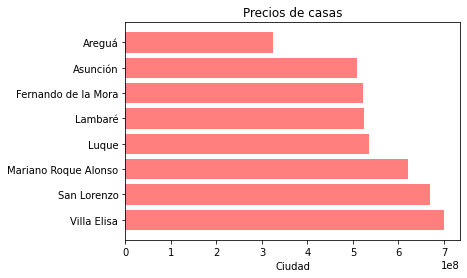

In [36]:
x = central_group['ciudad']
y = central_group['precio_gs']

# plot
plt.figure(figsize=(50, 30))

fig, ax = plt.subplots()

ax.barh(x, sorted(y), color='red', alpha=0.5)
#ax.barh(x, y, edgecolor="white", linewidth=0.7)
#ax.set_yticks(x, labels=ciudad)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Ciudad')
ax.set_title('Precios de casas')
plt.show()